# Mục lục
1. [Giới thiệu](#giới-thiệu)
    - [Đề tài và thành viên](#giới-thiệu)
    - [Nội dung mô phỏng](#nội-dung-mô-phỏng)
2. [Xây dựng mô phỏng](#hiện-thực-mô-phỏng)
    - [Định nghĩa Job và Server](#định-nghĩa-job-và-server)
    - [Xây dựng hàng chờ M/M/1](#xây-dựng-hàng-chờ-mm1)
    - [Xây dựng hàng chờ M/G/1](#xây-dựng-hàng-chờ-mg1)
    - [Hiện thực mô phỏng](#hiện-thực-mô-phỏng)
3. [Đánh giá](#đánh-giá)

# Giới thiệu

**Thành viên**

1. Lương Hữu Phú Lợi - 1911545
2. Cao Thanh Lương - 1914076
4. Nguyễn Văn Việt - 1912446

**Đề tài 13**

Xây dựng 1 chương trình mô phỏng hàng M/G/1, 
trong đó thời gian phục vụ của server = d + S (S biến ngẫu nhiên phân bố theo hàm mũ và d tương tự như thời gian bắt buộc phải có khi xử lý 1 customer). 

Hãy so sánh hiệu năng với hàng M/M/1 với cùng tốc độ phục vụ trung bình 




## Nội dung mô phỏng

**Mục tiêu**
1. Xây dựng hàng chờ M/G/1 trong đó thời gian phục vụ của server = d + S (S biến ngẫu nhiên phân bố theo hàm mũ và d tương tự như thời gian bắt buộc phải có khi xử lý 1 customer)
2. So sánh hiệu năng hàng chờ M/M/1 và M/G/1 

**Giới hạn**

Nhóm sử dụng trang web cá nhân localhost : "React(frontend) + Java(backend) + MySQL" và một số các nguồn tài liệu khác trên mạng để chọn lựa dữ liệu các tham số cũng như các công thức tính.

Trong bài làm, nhóm xem 1 người dùng sẽ tạo ra 1 job cho mỗi công việc của người dùng đó, VD: việc đọc thông tin của 1 trang web là 1 job. Trong 1 job sẽ chỉ có 1 request gửi đến server và 1 request sẽ bao gồm tất cả các package, data gửi đi/nhận về.

Vì việc mô phỏng nhằm mục đích hỗ trợ cho việc đánh giá hệ thống đơn giản nên nhóm chỉ thực hiện trong vòng 1 phút (=60000 ms) và giả sử 1 server có thể đáp ứng trung bình 15 request trong 1 giây (trang localhost), nhận trung bình 12 request mới mỗi giây (trang OpenStreetMap.com)

Hệ thống sẽ thực hiện theo mô hình **FIFO** 

Tại hàng chờ M/G/1, phân phối theo General sẽ có tham số **d** (deviation) là thời gian bắt buộc phải có thì nhóm giả sử đây là thời gian này sẽ bằng 10% của service time trung bình ([hardware delay](https://dgway.com/blog_E/2021/02/22/measuring-latency-time/))


**Dữ liệu sử dụng**

Vì đây là hiện thực mô phỏng đơn giản nên nhóm sẽ sử dụng các dữ liệu cơ bản gồm: 
1. MAXSIMTIME  (60000ms)
2. MU (~12)          được lấy từ thời gian xử lý của trang web localhost
3. LAMBDA (~15)      được tham khảo từ các nguồn tài liệu trên mạng
4. DEVIATION 


**Các nguồn tham khảo dữ liệu**
- Trang web localhost:
    - [Frontend](https://github.com/luongcaothanh/LearningSystemFrontend)
    - [Backend](https://github.com/luongcaothanh/LearningSystemBackend)

- Các nguồn khác:
    - [Architectures under E-Commerce Workloads](https://www.ele.uri.edu/Research/hpcl/DRALIC/JPDC.pdf)
    - [Avarage request per second](https://stackoverflow.com/questions/373098/whats-the-average-requests-per-second-for-a-production-web-application)
    - [How many user online at a time](https://www.quora.com/How-many-average-users-online-at-a-time-does-it-take-to-make-500-requests-per-second-or-30-000-requests-per-minute)
    - [Analyses of M/M/1 and M/G/1](https://antaresc.github.io/src/documents/classes/cs162-mm1-mg1.pdf)
    - [Analysis of the M/G/1 queue with exponentially working vacations](http://gljc.sxu.edu.cn/docs/2013-11/20131129080953362966.pdf)




***
# Xây dựng mô phỏng

## Định nghĩa Job và Server 

**Import of required modules**

In [477]:
import simpy
import numpy as np
import numpy.random as random

**Parameters settings**

In [478]:
MAXSIMTIME = 60000

VERBOSE = True 

# Trong 1 giây ĐẾN 12.0 job
LAMBDA = 12.0

# Trong 1 giây PHỤC VỤ  15 job
MU = 15.0


# có tổng số 50 triệu job (~ vô hạn job)
POPULATION = 50000000


# SERVICE_DISCIPLINE = 'SJF'
SERVICE_DISCIPLINE = 'FIFO'


LOGGED = True


PLOTTED = True

**Discrete-Event Simulation model**


**The definition of a job**.

The properties of a **job** are:
1. job execution time
2. job arrival time

In [479]:
class Job:
    def __init__(self, name, arrtime, duration):
        self.name = name
        self.arrtime = arrtime
        self.duration = duration

    def __str__(self):
        return '%s at %d, length %d' %(self.name, self.arrtime, self.duration)

**The definition of server**


 There are 2 arguments needed for a server:
 1. env: SimPy environment
 2. queue discipline: 
   - FIFO: First In First Out


In [480]:
class Server:
    def __init__(self, env, strat = 'FIFO'):
        self.env = env
        self.strat = strat
        self.Jobs = list(())
        self.serversleeping = None
        ''' statistics '''
        self.waitingTime = 0
        self.idleTime = 0
        self.jobsDone = 0
        
        self.serviceTime = 0
        self.queueLength = 0

        # self.tmpTime = 0
        ''' register a new server process '''
        env.process( self.serve() )

    def serve(self):
        while True:
            ''' do nothing, just change server to idle
              and then yield a wait event which takes infinite time
            ''' 
            if len( self.Jobs ) == 0 :
                self.serversleeping = env.process( self.waiting( self.env ))
                t1 = self.env.now
                yield self.serversleeping
                ''' accumulate the server idle time'''
                self.idleTime += self.env.now - t1
                # self.queueLength += len(self.Jobs)*(self.env.now - t1)
                
            else:              
                ''' get the first job to be served'''
                j = self.Jobs.pop( 0 )
                if LOGGED:
                    qlog.write( '%.5f\t%d\t%d\t%.5f\n' 
                        % (self.env.now, 1 if len(self.Jobs)>0 else 0, len(self.Jobs), j.duration) )

                ''' sum up the waiting time'''
                self.waitingTime += self.env.now - j.arrtime
                
                ''' sum up service time'''
                self.serviceTime += j.duration
                
                ''' sum up number of jobs in queue'''
                # self.queueLength.append(len(self.Jobs))
                # self.queueLength += len(self.Jobs)
                self.queueLength += len(self.Jobs)
                # self.queueLength += len(self.Jobs)*(self.env.now - self.tmpTime)
                # tmpTime = self.env.now
                
                ''' yield an event for the job finish'''
                yield self.env.timeout( j.duration )
                ''' sum up the jobs done '''
                self.jobsDone += 1
                # self.queueLength += len(self.Jobs)*(self.env.now - tmpTime)
                
                

    def waiting(self, env):
        try:
            if VERBOSE:
                # print( 'Server is idle at %.2f' % self.env.now )
                slog.write('\nServer is idle at %.5f \n\n' % self.env.now)
                
            yield self.env.timeout( MAXSIMTIME )
        except simpy.Interrupt as i:
            if VERBOSE:
                #  print('Server waken up and works at %.2f' % self.env.now )
                 slog.write('Server waken up and works at %.5f \n\n' % self.env.now)

***
## Xây dựng hàng chờ M/M/1

**The arrival process**

The arrival process is exponentially distributed which is parameterized by
1. number of servers
2. maximum number of population
3. arrival rate $\lambda$
4. service rate $\mu$

*Note that, the implementation of the arrival process embeds both arrival and service distributions.*

In [481]:
class mm1JobGenerator:
    def __init__(self, env, server, nrjobs = 10000000, lam = 12, mu = 15):
        self.server = server
        self.nrjobs = nrjobs
        self.interarrivaltime = 1/lam
        self.servicetime = 1/mu
        
        # self.queueLength = 0
        
        
        
        env.process( self.generatejobs(env) )
        
        
    def generatejobs(self, env):
        i = 1
        while True:
            '''yield an event for new job arrival'''
            job_interarrival = random.exponential( self.interarrivaltime )
            yield env.timeout( job_interarrival )

            ''' generate service time and add job to the list'''
            job_duration = random.exponential( self.servicetime )
            self.server.Jobs.append( Job('Job %s' %i, env.now, job_duration) )
            
            # self.medTime.append(job_duration)
            # self.server.queueLength += len(self.server.Jobs)*(job_interarrival)
            # self.server.queueLength += len(self.server.Jobs)*(env.now - self.server.tmpTime)
            
            # self.server.tmpTime = env.now
            
            if VERBOSE:
                # print( 'job %d: t = %.2f, l = %.2f, dt = %.2f' 
                    # %( i, env.now, job_duration, job_interarrival ) )
                slog.write('job %d: t = %.2f, l = %.5f, dt = %.5f \n' 
                    %( i, env.now, job_duration, job_interarrival ))
            i += 1

            ''' if server is idle, wake it up'''
            if not self.server.serversleeping.triggered:
                self.server.serversleeping.interrupt( 'Wake up, please.' )
                slog.write('\nWake up, please \n' )


***
## Xây dựng hàng chờ M/G/1

**The arrival process**

The arrival process is exponentially distributed which is parameterized by
1. number of servers
2. maximum number of population
3. arrival rate $\lambda$
4. service rate $\mu$
5. **deviation** of service rate  **d**

*Note that, the implementation of the arrival process embeds both arrival and service distributions.*

In [482]:
class mg1JobGenerator:
    def __init__(self, env, server, nrjobs = 10000000, lam = 12, mu = 15):
        self.server = server
        self.nrjobs = nrjobs
        self.interarrivaltime = 1/lam
        self.servicetime = 1/mu
        self.d = self.servicetime/5
      
        self.medTime = list()
        
        # self.queueLength = 0
        
        
        env.process( self.generatejobs(env) )
        
        
    def generatejobs(self, env):
        i = 1
        while True:
            '''yield an event for new job arrival'''
            job_interarrival = random.exponential( self.interarrivaltime )
            yield env.timeout( job_interarrival )

            ''' generate service time and add job to the list'''
            job_duration = random.exponential( self.servicetime ) + self.d
            self.server.Jobs.append( Job('Job %s' %i, env.now, job_duration) )
            
            # self.server.queueLength += len(self.server.Jobs)*(job_interarrival)
            # self.server.queueLength += len(self.server.Jobs)*(env.now - self.server.tmpTime)
            # self.server.tmpTime = env.now
            self.medTime.append(job_duration)
            
            if VERBOSE:
                # print( 'job %d: t = %.2f, l = %.2f, dt = %.2f' 
                    # %( i, env.now, job_duration, job_interarrival ) )
                slog.write('job %d: t = %.2f, l = %.5f, dt = %.5f \n' 
                    %( i, env.now, job_duration, job_interarrival ))
            i += 1

            ''' if server is idle, wake it up'''
            if not self.server.serversleeping.triggered:
                self.server.serversleeping.interrupt( 'Wake up, please.' )
                slog.write('\nWake up, please \n' )


***
**Phép tính các thông số**

- *queueLength* : chiều dài hàng chờ trung bình được tính bằng cách tích phân liên tục trong suốt thời gian thực hiện hệ thống, do đó nhóm trung bình hàng chờ trong mô phỏng theo cách sẽ tính độ dài queue tại mỗi thời gian có job vào hoặc ra

(*chiều dài hàng chờ tại 1 thời gian* x *từng khoảng thời gian*) / *tổng thời gian thực hiện*


*** 
## Hiện thực mô phỏng

Thực hiện các tính toán và lưu lại thành 3 file bao gồm:
1. log-cpu: Ghi lại toàn bộ hoạt động của cpu xử lý, bao gồm idle time, service time, job generate
2. mg1/mm1: ghi lại các khoảng thời gian cpu idle hay busy và số lượng job trong queue tại các thời điểm
3. result: ghi lại kết quả các phép tính thực tế so với lý thuyết



**Thay đổi các tham số**

In [483]:
LAMBDA = 12.0
MU = 15.0

**Hàng chờ M/M/1**

In [484]:
qlog = open( 'mm1-l%d-m%d.csv' % (LAMBDA,MU), 'w' )
qlog.write( '0\t0\t0\t0\n' )
slog = open('log-cpu-mm1-l%d-m%d.txt' % (LAMBDA,MU), 'w')
slog.write('logging running things: \n')

env = simpy.Environment()
MyServer = Server( env, SERVICE_DISCIPLINE )
MyJobGenerator = mm1JobGenerator( env, MyServer, POPULATION, LAMBDA, MU )

env.run( until = MAXSIMTIME )

qlog.close()
slog.close()

'''Storage Simulation data '''
RHO = LAMBDA/MU 

result = open( 'result-mm1-l%d-m%d.txt' % (LAMBDA,MU), 'w' )

result.write('Arrivals               : %d jobs' % (MyServer.jobsDone))

result.write( '\nUtilization            : %.5f/%.5f ' 
    % (1.0-MyServer.idleTime/MAXSIMTIME, RHO) )

result.write( '\nMean waiting time      : %.5f/%.5f ' 
    % (MyServer.waitingTime/MyServer.jobsDone, RHO**2/((1-RHO)*LAMBDA) ) )

result.write( '\nMean service time      : %.5f/%.5f ' 
    % (MyServer.serviceTime/MyServer.jobsDone, 1/MU))

result.write( '\nMean system time       : %.5f/%.5f ' 
    % ((MyServer.waitingTime+MyServer.serviceTime)/MyServer.jobsDone, 1/(MU-LAMBDA)))


result.write( '\nMean jobs in queue     : %.5f/%.5f'
    % (MyServer.queueLength/MyServer.jobsDone, (RHO**2/((1-RHO)))))

result.close()



***
**Hàng chờ M/G/1**

In [485]:
qlog = open( 'mg1-l%d-m%d.csv' % (LAMBDA,MU), 'w' )
qlog.write( '0\t0\t0\t0\n' )
slog = open('log-cpu-mg1-l%d-m%d.txt' % (LAMBDA,MU), 'w')
slog.write('logging running things: \n')

env = simpy.Environment()
MyServer2 = Server( env, SERVICE_DISCIPLINE )
MyJobGenerator2 = mg1JobGenerator( env, MyServer2, POPULATION, LAMBDA, MU)

env.run( until = MAXSIMTIME )

qlog.close()
slog.close()

'''Tính Deviation and coefficient dựa trên list dữ liệu service time (medTime)'''
RHO = LAMBDA/MU 
DEVIATION = np.std(MyJobGenerator2.medTime)
COEFFICIENT = DEVIATION/(1/MU)
# COEFFICIENT = 0.1


result = open( 'result-mg1-l%d-m%d.txt' % (LAMBDA,MU), 'w' )

result.write('Arrivals               : %d jobs' % (MyServer2.jobsDone))

result.write( '\nUtilization            : %.5f/%.5f ' 
    % (1.0-MyServer2.idleTime/MAXSIMTIME, RHO) )

result.write( '\nMean waiting time      : %.5f/%.5f ' 
    % (MyServer2.waitingTime/MyServer2.jobsDone, (RHO/MU)*(1+COEFFICIENT**2) / (2-2*RHO) ))

result.write( '\nMean service time      : %.5f/%.5f ' 
    % (MyServer2.serviceTime/MyServer2.jobsDone, 1/MU))

result.write( '\nMean system time       : %.5f/%.5f ' 
    % ((MyServer2.waitingTime+MyServer2.serviceTime)/MyServer2.jobsDone, (1/MU) + (RHO*(1/MU)*(1+COEFFICIENT**2)) / (2*(1-RHO)) ))

result.write( '\nMean jobs in queue     : %.5f/%.5f'
    % (MyServer2.queueLength/MyServer2.jobsDone, RHO + ((RHO**2)*(1+COEFFICIENT**2))/(2*(1-RHO))))

result.close()

***
# Đánh giá 

## Với $\lambda$ = 12 và $\mu$ = 15

In [486]:
print('M/M/1 data: ')
f = open( 'result-mm1-l12-m15.txt' , 'r' )
content_file = f.read()
print(content_file)
f.close()

print('\n**********************************\n')
print('M/G/1 data:')
f = open( 'result-mg1-l12-m15.txt' , 'r' )
content_file = f.read()
print(content_file)
f.close()

M/M/1 data: 
Arrivals               : 720269 jobs
Utilization            : 0.80115/0.80000 
Mean waiting time      : 0.26826/0.26667 
Mean service time      : 0.06674/0.06667 
Mean system time       : 0.33500/0.33333 
Mean jobs in queue     : 3.21291/3.20000

**********************************

M/G/1 data:
Arrivals               : 719416 jobs
Utilization            : 0.96002/0.80000 
Mean waiting time      : 1.65490/0.26683 
Mean service time      : 0.08007/0.06667 
Mean system time       : 1.73496/0.33349 
Mean jobs in queue     : 19.85350/4.00191


**Nhận xét**

Đầu tiên, về số lượng các job đã thực hiện trong cùng 1 khoảng thời gian thì cả 2 hàng chờ không có sự chệnh lệch quá lớn.
Tuy nhiên, tại hàng chờ của MG1, tỷ lệ tối ưu (*utilization*) lại cao hơn so với MM1. 

Về thời gian xử lý các job, trung bình thời gian mà hàng MG1 cần sẽ cao hơn khoảng 10% (là mức thời gian *d* đã cho trước), điều này làm cho thời gian mà các job trong queue chờ đến lược xử lý gần như tăng gắp đôi (~1.8 lần) so với MM1.
Về lý thuyết dự tính, thời gian chờ đến lượt của job trong MG1 và MM1 gần bằng nhau nhưng khi mô phỏng thực tế, khoảng thời gian này ở MG1 đã ở mức cao hơn nhiều. 

Với tổng thời gian ở trong hệ thống, cả 2 hàng chờ cho kết quả khá gần nhau về lý thuyết nhưng khi chạy dữ liệu mô phỏng, MG1 đã tăng cao hơn MM1 khoảng 65%. 

Việc tăng thời gian xử lý đã dẫn đến thời gian chờ của Job tăng lên cao làm cho trong cùng 1 khoảng thời gian, số lượng job trung bình trong queue của hàng MG1 cao gần gắp đôi MM1 (~1.79 lần). Điều này có nghĩa là người dùng trang web sẽ thường gặp vấn đề xử lý chậm hơn nhiều. Tuy nhiên, hàng chờ MG1 lại có số job đã xử lý cao hơn một chút so với MM1.

Từ việc này, ta có thể thấy việc thay đổi thời gian xử lý không làm cho thời gian của job trong hệ thống tăng theo cách tuyến tính mà tăng thời gian xử lý job của server lên thêm 10% có thể dẫn đến việc xứ lý job trong toàn bộ hệ thống sẽ tăng gần gấp đôi.

*** 
## Nhận xét MM1



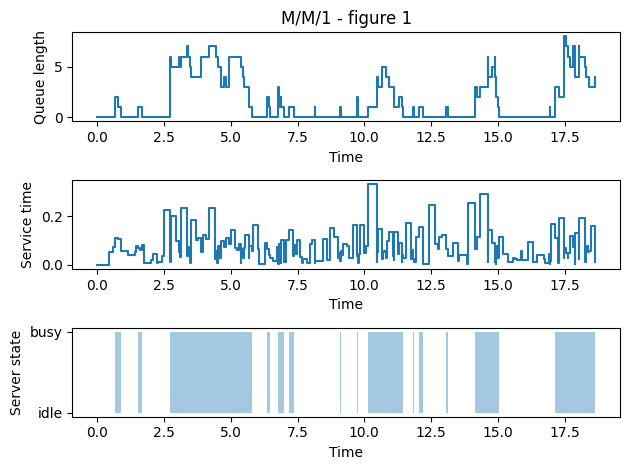

In [487]:
if LOGGED and PLOTTED:
    import matplotlib.pyplot as plt
    log = np.loadtxt( 'mm1-l12-m15.csv', delimiter = '\t' )
    plt.subplot( 3, 1, 1 )
    plt.subplot( 3, 1, 1 ).set_title('M/M/1 - figure 1')
    plt.xlabel( 'Time' )
    plt.ylabel( 'Queue length' )
    plt.step( log[:200,0], log[:200,2], where='post' )
    
    plt.subplot( 3, 1, 2 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Service time' )
    plt.step( log[:200,0], log[:200,3], where='post' )
    # plt.fill_between( log[:300,0], 0, log[:300,1], step="post", alpha=.4 )
    
    plt.subplot( 3, 1, 3 )
    # plt.subplot( 2, 1, 2 ).set_title('fig 2')
    plt.xlabel( 'Time' )
    plt.ylabel( 'Server state' )
    plt.yticks([0, 1], ['idle', 'busy'])
    # plt.step( log[:200,0], log[:200,1], where='post' )
    plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4 )
    plt.tight_layout()
    plt.show()
    

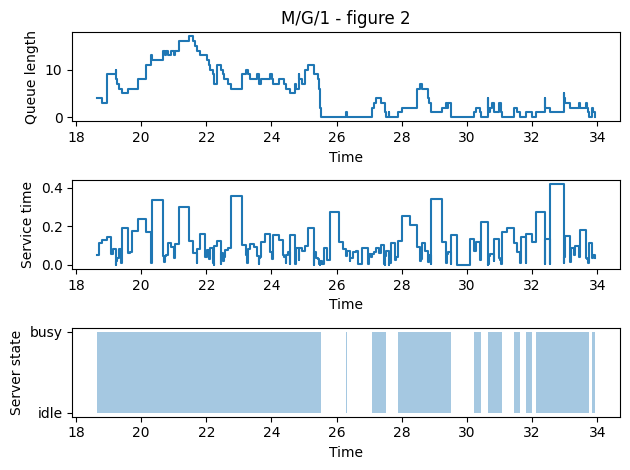

In [488]:
import matplotlib.pyplot as plt
log = np.loadtxt( 'mm1-l12-m15.csv', delimiter = '\t' )
plt.subplot( 3, 1, 1 )
plt.subplot( 3, 1, 1 ).set_title('M/G/1 - figure 2')
plt.xlabel( 'Time' )
plt.ylabel( 'Queue length' )
plt.step( log[200:400,0], log[200:400,2], where='post' )

plt.subplot( 3, 1, 2 )
plt.xlabel( 'Time' )
plt.ylabel( 'Service time' )
plt.step( log[200:400,0], log[200:400,3], where='post' )
# plt.fill_between( log[:300,0], 0, log[:300,1], step="post", alpha=.4 )

plt.subplot( 3, 1, 3 )
# plt.subplot( 2, 1, 2 ).set_title('fig 2')
plt.xlabel( 'Time' )
plt.ylabel( 'Server state' )
plt.yticks([0, 1], ['idle', 'busy'])
# plt.step( log[:200,0], log[:200,1], where='post' )
plt.fill_between( log[200:400,0], 0, log[200:400,1], step="post", alpha=.4 )
plt.tight_layout()
plt.show()
    

Đầu tiên, tại hàng chờ, sớ lượng các job trong queue trong khoảng thời gian tầm 1s sau khi chạy thì hầu như số lượng các job trong queue rất ít, gần như các job đến đều được xử lý ngay lập tức. Tuy nhiên, kể từ giây 1 đến khoảng giây 2.6 thì số lượng job tăng mạnh và được giữ vững ở mức tầm 5 job trong queue. Về sau thì số lượng job được giảm nhiều cho đến giây thứ 3 và sau đó tăng lại rồi giảm dần đến hết vào thời điểm 5s. Lúc sau, hệ thống có số lượng job trong queue được giữ ở mức tốt ( thấp hơn 3) nhưng đến khoảng giây thứ 9 thì số lượng job đến tăng đột ngột làm cho số job trong queue tăng mạnh và giảm đột ngột sau giây thứ 11. Nhưng sau giây thứ 12 thì số lượng job lại tăng còn mạnh hơn cả 2 lần trước và được giữ vững trong 1 thời gian dài.

Tại bảng **M/M/1 - figure 2**, ta có thể thấy số lượng job trong queue giảm dần ở giây thứ 16 đến giây thứ 18. KẾ tiếp là một đợt nghỉ dài của server theo như bàng *Server state*. Kế từ sau giây thứ 21, ta có thể thấy có hiện lặp lại của chu kì hoạt động của server vào giai đoạn giây thứ 21, 23 và 28 tương ứng với 3 lần tăng số lượng job trong queue của hình trên.

Tại bảng *Service time*, ta có thể thấy các khoảng thời gian cần xử lý của các job. Vào các thời điểm mà số lượng job trong queue tăng dần thì các khoảng thời gian này có độ chênh lệch không nhiều như khi server đang "trống"


*** 
## Nhận xét MG1


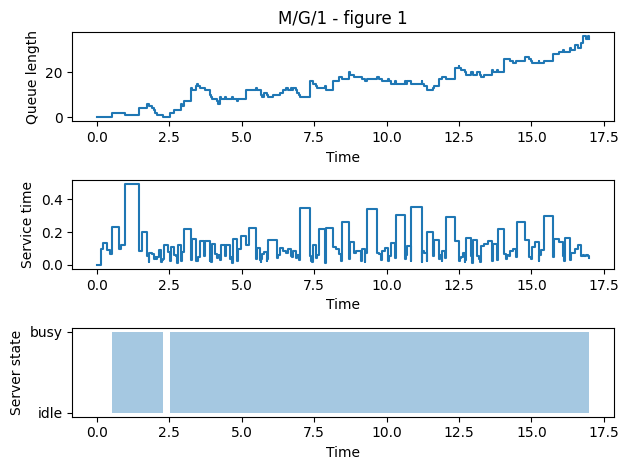

In [489]:
if LOGGED and PLOTTED:
    import matplotlib.pyplot as plt
    log = np.loadtxt( 'mg1-l12-m15.csv', delimiter = '\t' )
    plt.subplot( 3, 1, 1 )
    plt.subplot( 3, 1, 1 ).set_title('M/G/1 - figure 1')
    plt.xlabel( 'Time' )
    plt.ylabel( 'Queue length' )
    plt.step( log[:200,0], log[:200,2], where='post' )
    
    plt.subplot( 3, 1, 2 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Service time' )
    plt.step( log[:200,0], log[:200,3], where='post' )
    # plt.fill_between( log[:300,0], 0, log[:300,1], step="post", alpha=.4 )
    
    plt.subplot( 3, 1, 3 )
    # plt.subplot( 2, 1, 2 ).set_title('fig 2')
    plt.xlabel( 'Time' )
    plt.ylabel( 'Server state' )
    plt.yticks([0, 1], ['idle', 'busy'])
    # plt.step( log[:200,0], log[:200,1], where='post' )
    plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4 )
    plt.tight_layout()
    plt.show()
    
    

Khác với mô hình MM1, MG1 cho thấy độ lệch giữa số lượng các job trong queue và thời gian cần cho job được thực hiện ở mức lớn và không theo quy luật nào. Tại thời điểm đầu, số lượng các job trong queue có biểu đồ khá giống với MM1  từ 0s - 3s. Mãi đến giây thứ 4, MG1 mới bắt đầu có hiện tượng tăng nhưng vẫn còn trong tình trạng "ổn" ( dưới 5 job). Tuy nhiên, sau khoảng thời gian 6 giây thì số lượng job tăng mạnh và kéo dài khoảng 1 giây và giảm nhanh xuống. Nhưng chưa được bao lâu thì số lượng job trong queue bắt đầu tăng nhanh và có sự "thắt cổ chai" vào giây thứ 11 khi số lượng job vượt qua 10 job. Sau đó, hàng chờ giảm dần cho đến giây 12.5 và không có sự biến thiên nào lớn trong khoảng 2.5 giây kế tiếp. Sau giây 15.5 thì bắt đầu có sự biến thiên mạnh trong các khoảng thời gian sau bằng việc tăng lên rất nhanh nhưng cũng giảm nhanh. Thời gian "nghỉ" sau giảm  của MG1 ở các thời điểm sau tương đối ngắn so với MM1 và độ biến thiên rất lớn giữa các lần tăng giảm.

Trong bảng *Service time*, ta có thể thấy việc các khoảng thời gian không phân bố đều mà có sự chênh lệch lớn với số lần tăng đến 0.4ms  nhiều hơn hẳn so với MM1.

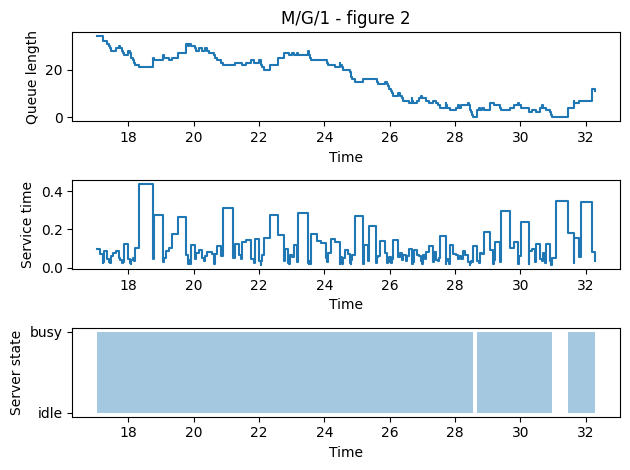

In [490]:
import matplotlib.pyplot as plt
log = np.loadtxt( 'mg1-l12-m15.csv', delimiter = '\t' )
plt.subplot( 3, 1, 1 )
plt.subplot( 3, 1, 1 ).set_title('M/G/1 - figure 2')
plt.xlabel( 'Time' )
plt.ylabel( 'Queue length' )
plt.step( log[200:400,0], log[200:400,2], where='post' )

plt.subplot( 3, 1, 2 )
plt.xlabel( 'Time' )
plt.ylabel( 'Service time' )
plt.step( log[200:400,0], log[200:400,3], where='post' )
# plt.fill_between( log[:300,0], 0, log[:300,1], step="post", alpha=.4 )

plt.subplot( 3, 1, 3 )
# plt.subplot( 2, 1, 2 ).set_title('fig 2')
plt.xlabel( 'Time' )
plt.ylabel( 'Server state' )
plt.yticks([0, 1], ['idle', 'busy'])
# plt.step( log[:200,0], log[:200,1], where='post' )
plt.fill_between( log[200:400,0], 0, log[200:400,1], step="post", alpha=.4 )
plt.tight_layout()
plt.show()

## Kết luận

Thông qua việc đánh giá thời gian xử lý, số lượng job trong queue,... của cả hai hàng chờ, ta có thể thấy hàng chờ MM1 có tính quy luật hơn khi lặp lại sau 3 lần tăng mạnh số job trong queue với số lượng tăng tương ứng sau mỗi lần nhưng sau đó thì sớ lượng tăng giảm về giống phần đầu của chu kì. Trong khi đó, số lượng job trong queue của hàng MG1 có sự biến thiên không có tính quy luật và độ lệch giữa các lần tăng giảm lớn hơn nhiều so với MM1. Khoảng các giữa các lần server idle của MG1 cũng ít hơn nhiều so với MM1.

Từ những việc này, ta có thể thấy với cùng tốc độ phục vụ, cả 2 hàng chờ đều phục vu sớ lượng job gần như nhau (MG1 có phần nhỉnh hơn MM1) tuy nhiên thời gian xử lý và số lượng job trong queueu của MG1 lại cao gần gắp đôi MM1 dù thời gian phục vụ chỉ tăng 10%. Việc này xảy ra do một phần độ biến thiên số lượng job trong queue và thời gian cần xử lý job của MG1 lớn hơn hẳn so với MM1, dẫn đến việc xử lý gặp "*nút cổ chai*" khi số lượng job đến vượt qua 1 ngượng nhất định.

Cuối cùng, vì việc mô phòng này sử dụng các số liệu không chính quy, thu nhặt từ nhiều nguồn khác nhau và có các "giả sử" nên việc mô phỏng này chưa được chính xác và phù hợp với thực tế. Vì vậy, việc mô phỏng này cần được nghiên cưu thêm và sử dụng các thông số chính xác và phù hợp thực tế hơn.

***
## Thay đổi một số thông số khác

### Với $\lambda$ = 10 và $\mu$ = 15

Với một Linux Sever thì 

In [491]:
print('M/M/1 data: ')
f = open( 'result-mm1-l10-m15.txt' , 'r' )
content_file = f.read()
print(content_file)
f.close()

print('\n**********************************\n')
print('M/G/1 data:')
f = open( 'result-mg1-l10-m15.txt' , 'r' )
content_file = f.read()
print(content_file)
f.close()

M/M/1 data: 
Arrivals               : 599462 jobs
Utilization            : 0.66692/0.66667 
Mean waiting time      : 0.13248/0.13333 
Mean service time      : 0.06675/0.06667 
Mean system time       : 0.19924/0.20000 
Mean jobs in queue     : 1.31758/1.33333

**********************************

M/G/1 data:
Arrivals               : 600087 jobs
Utilization            : 0.80105/0.66667 
Mean waiting time      : 0.27204/0.13359 
Mean service time      : 0.08009/0.06667 
Mean system time       : 0.35213/0.20026 
Mean jobs in queue     : 2.71424/2.00259


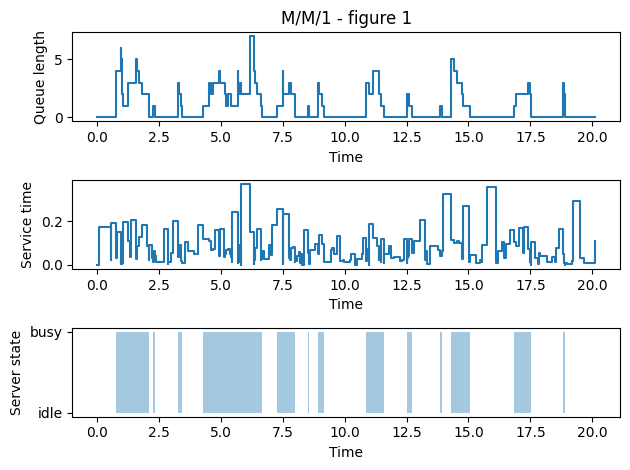

In [492]:
if LOGGED and PLOTTED:
    import matplotlib.pyplot as plt
    log = np.loadtxt( 'mm1-l10-m15.csv', delimiter = '\t' )
    plt.subplot( 3, 1, 1 )
    plt.subplot( 3, 1, 1 ).set_title('M/M/1 - figure 1')
    plt.xlabel( 'Time' )
    plt.ylabel( 'Queue length' )
    plt.step( log[:200,0], log[:200,2], where='post' )
    
    plt.subplot( 3, 1, 2 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Service time' )
    plt.step( log[:200,0], log[:200,3], where='post' )
    # plt.fill_between( log[:300,0], 0, log[:300,1], step="post", alpha=.4 )
    
    plt.subplot( 3, 1, 3 )
    # plt.subplot( 2, 1, 2 ).set_title('fig 2')
    plt.xlabel( 'Time' )
    plt.ylabel( 'Server state' )
    plt.yticks([0, 1], ['idle', 'busy'])
    # plt.step( log[:200,0], log[:200,1], where='post' )
    plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4 )
    plt.tight_layout()
    plt.show()
    

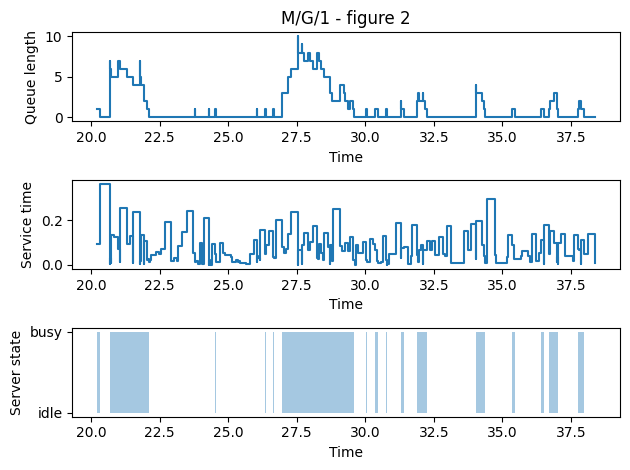

In [493]:
import matplotlib.pyplot as plt
log = np.loadtxt( 'mm1-l10-m15.csv', delimiter = '\t' )
plt.subplot( 3, 1, 1 )
plt.subplot( 3, 1, 1 ).set_title('M/G/1 - figure 2')
plt.xlabel( 'Time' )
plt.ylabel( 'Queue length' )
plt.step( log[200:400,0], log[200:400,2], where='post' )

plt.subplot( 3, 1, 2 )
plt.xlabel( 'Time' )
plt.ylabel( 'Service time' )
plt.step( log[200:400,0], log[200:400,3], where='post' )
# plt.fill_between( log[:300,0], 0, log[:300,1], step="post", alpha=.4 )

plt.subplot( 3, 1, 3 )
# plt.subplot( 2, 1, 2 ).set_title('fig 2')
plt.xlabel( 'Time' )
plt.ylabel( 'Server state' )
plt.yticks([0, 1], ['idle', 'busy'])
# plt.step( log[:200,0], log[:200,1], where='post' )
plt.fill_between( log[200:400,0], 0, log[200:400,1], step="post", alpha=.4 )
plt.tight_layout()
plt.show()
    

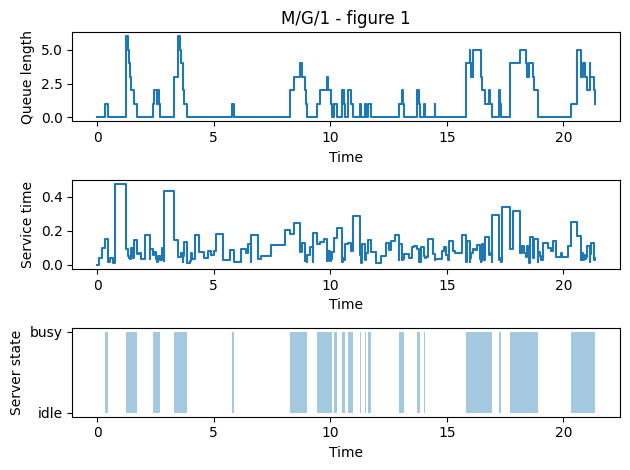

In [494]:
if LOGGED and PLOTTED:
    import matplotlib.pyplot as plt
    log = np.loadtxt( 'mg1-l10-m15.csv', delimiter = '\t' )
    plt.subplot( 3, 1, 1 )
    plt.subplot( 3, 1, 1 ).set_title('M/G/1 - figure 1')
    plt.xlabel( 'Time' )
    plt.ylabel( 'Queue length' )
    plt.step( log[:200,0], log[:200,2], where='post' )
    
    plt.subplot( 3, 1, 2 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Service time' )
    plt.step( log[:200,0], log[:200,3], where='post' )
    # plt.fill_between( log[:300,0], 0, log[:300,1], step="post", alpha=.4 )
    
    plt.subplot( 3, 1, 3 )
    # plt.subplot( 2, 1, 2 ).set_title('fig 2')
    plt.xlabel( 'Time' )
    plt.ylabel( 'Server state' )
    plt.yticks([0, 1], ['idle', 'busy'])
    # plt.step( log[:200,0], log[:200,1], where='post' )
    plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4 )
    plt.tight_layout()
    plt.show()
    
    

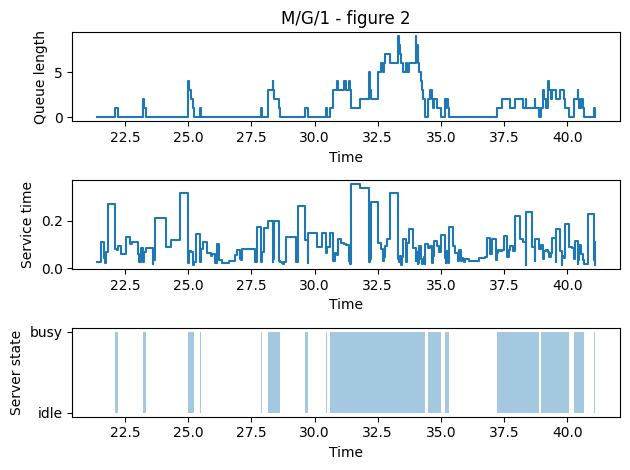

In [495]:
import matplotlib.pyplot as plt
log = np.loadtxt( 'mg1-l10-m15.csv', delimiter = '\t' )
plt.subplot( 3, 1, 1 )
plt.subplot( 3, 1, 1 ).set_title('M/G/1 - figure 2')
plt.xlabel( 'Time' )
plt.ylabel( 'Queue length' )
plt.step( log[200:400,0], log[200:400,2], where='post' )

plt.subplot( 3, 1, 2 )
plt.xlabel( 'Time' )
plt.ylabel( 'Service time' )
plt.step( log[200:400,0], log[200:400,3], where='post' )
# plt.fill_between( log[:300,0], 0, log[:300,1], step="post", alpha=.4 )

plt.subplot( 3, 1, 3 )
# plt.subplot( 2, 1, 2 ).set_title('fig 2')
plt.xlabel( 'Time' )
plt.ylabel( 'Server state' )
plt.yticks([0, 1], ['idle', 'busy'])
# plt.step( log[:200,0], log[:200,1], where='post' )
plt.fill_between( log[200:400,0], 0, log[200:400,1], step="post", alpha=.4 )
plt.tight_layout()
plt.show()